In [165]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [166]:
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [167]:
all_series = {
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
}

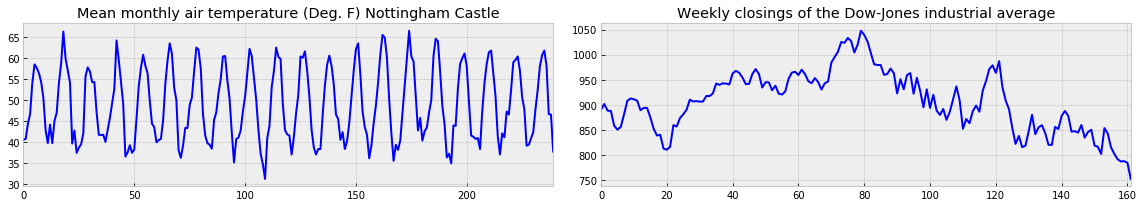

In [168]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Инициируем функции

In [169]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [170]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

In [171]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [172]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [173]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [174]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [175]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

### Первый ряд - индекс Доу Джонс

In [176]:
series_dd = pd.read_csv("weekly-closings-of-the-dowjones-.csv")['Close']

In [177]:
ma_dd = moving_average(series_dd, 7)

In [178]:
wma_fib_dd = weighted_moving_average(series_dd, 7, [1,1,2,3,5,8,13])
wma_pow_dd = weighted_moving_average(series_dd, 7, [1,2,4,8,16,32,64])

In [179]:
ema_dd = exponential_moving_average(series_dd, 0.2)

In [180]:
dema_dd = double_ema(series_dd, 0.5, 0.5)

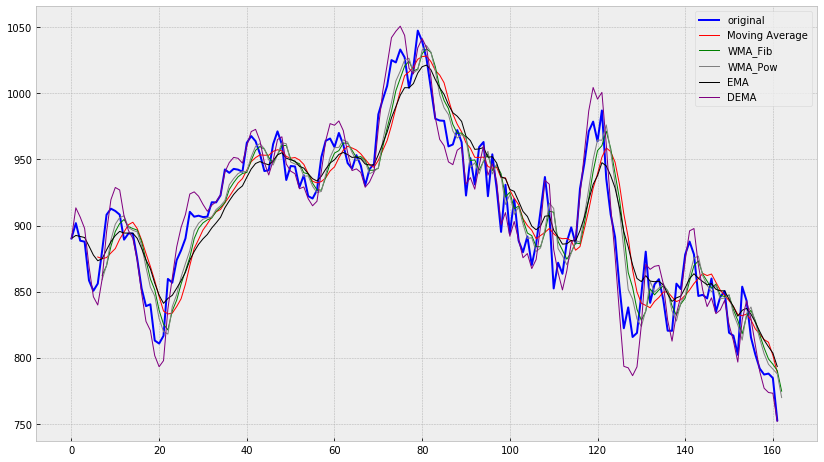

In [181]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_dd, color='blue',label='original')
    plt.plot(ma_dd, color='red', linewidth='1', label='Moving Average')
    plt.plot(wma_fib_dd, color='green', linewidth='1', label='WMA_Fib')
    plt.plot(wma_pow_dd, color='gray', linewidth='1', label='WMA_Pow')
    plt.plot(ema_dd, color='black', linewidth='1', label='EMA')
    plt.plot(dema_dd, color='purple', linewidth='1', label='DEMA')
    plt.legend()

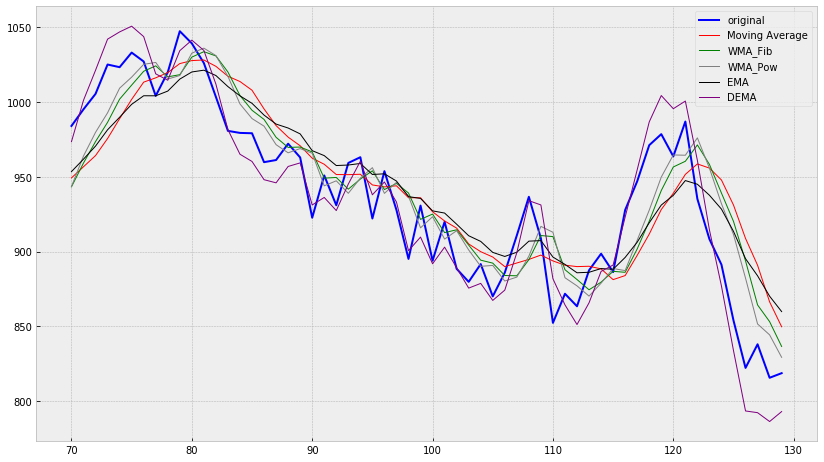

In [182]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_dd[70:130], color='blue',label='original')
    plt.plot(ma_dd[70:130], color='red', linewidth='1', label='Moving Average')
    plt.plot(wma_fib_dd[70:130], color='green', linewidth='1', label='WMA_Fib')
    plt.plot(wma_pow_dd[70:130], color='gray', linewidth='1', label='WMA_Pow')
    plt.plot(ema_dd[70:130], color='black', linewidth='1', label='EMA')
    plt.plot(dema_dd[70:130], color='purple', linewidth='1', label='DEMA')
    plt.legend()

DEMA лучше всего показывает изменение уровня в оригинале, хоть и вылетает в пиках. На других графиках хоть и нагляднее "направление", колебанния слишком сглажены

### Второй ряд - средняя температура

In [183]:
series_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

In [184]:
ma_temp = moving_average(series_temp, 7)

In [185]:
wma_fib_temp = weighted_moving_average(series_temp, 7, [1,1,2,3,5,8,13])
wma_pow_temp = weighted_moving_average(series_temp, 7, [1,2,4,8,16,32,64])

In [186]:
ema_temp = exponential_moving_average(series_temp, 0.7)

In [187]:
dema_temp = double_ema(series_temp, 0.9, 0.1)

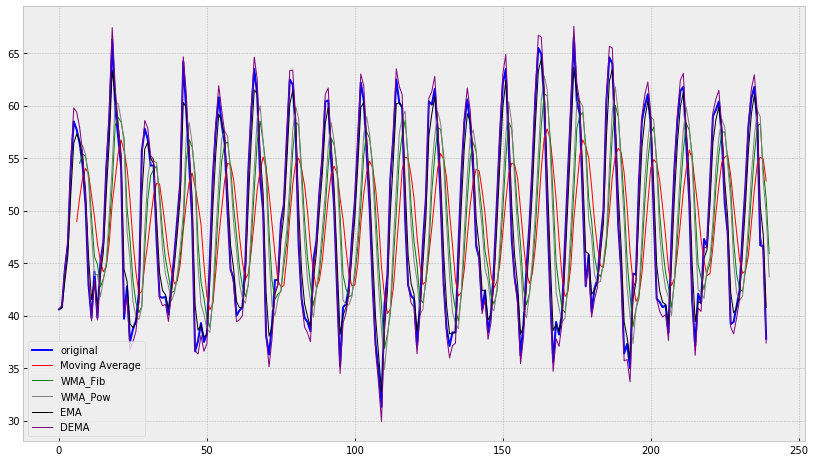

In [188]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_temp, color='blue',label='original')
    plt.plot(ma_temp, color='red', linewidth='1', label='Moving Average')
    plt.plot(wma_fib_temp, color='green', linewidth='1', label='WMA_Fib')
    plt.plot(wma_pow_temp, color='gray', linewidth='1', label='WMA_Pow')
    plt.plot(ema_temp, color='black', linewidth='1', label='EMA')
    plt.plot(dema_temp, color='purple', linewidth='1', label='DEMA')
    plt.legend()

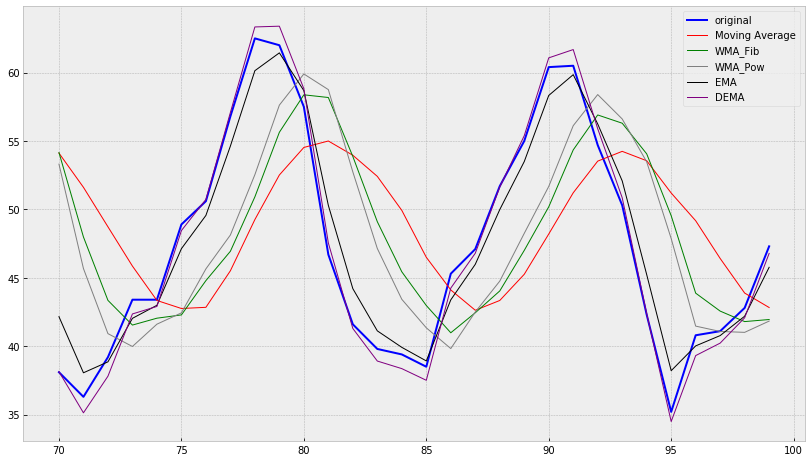

In [189]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_temp[70:100], color='blue',label='original')
    plt.plot(ma_temp[70:100], color='red', linewidth='1', label='Moving Average')
    plt.plot(wma_fib_temp[70:100], color='green', linewidth='1', label='WMA_Fib')
    plt.plot(wma_pow_temp[70:100], color='gray', linewidth='1', label='WMA_Pow')
    plt.plot(ema_temp[70:100], color='black', linewidth='1', label='EMA')
    plt.plot(dema_temp[70:100], color='purple', linewidth='1', label='DEMA')
    plt.legend()

Несмотря на то, что управляя значением alpha в EMA мы можем приблизить график к оригиналу, dema дает лучший результат. - удалось подобрать веса почти повторяющие график, хоть и с выбросами в пиковых значениях. Стандартный MA все же отстает от графика и лишь приблизительно показывает нам поведение уровня, хоть и с временным лагом. WMA лучше показывают колебания уровня, но тоже отстают. У этого графика етсь сезонность - попробуем построить для него TEMA.

In [190]:
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp["Deg"], ser_to_plot=mean_monthly_temp["Deg"], n_preds=0):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

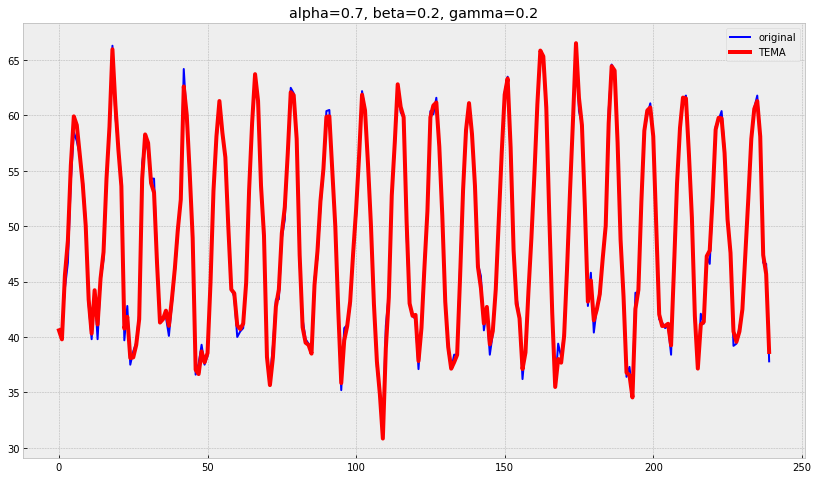

In [194]:
plot_tema(0.7, 0.2, 0.2)

С помощью настройки параметров можно почти полностью повторить первоначальный ряд